# A405 final problem

The cells below read in pres (hPa), hght (m), temp (C), dwpt (C) stored as a dataframe
in final_sounding.h5 dataframe 

For each question, insert a cell or cells that answers the question.  You are free to use any code in the github master branch, but double check before you hand in your notebook that it runs on a clean checkout of the
master branch (i.e. that you've included all your own code).

Hand in via email  (which may not work if the attachment is too big), or by sharing a dropbox-like url.

Due on Wednesday, April 20 at 9am.

Good luck, and don't hesitate to ask if anything is unclear.


In [251]:
import numpy as np
import pandas as pd
import pandas
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from importlib import reload
reload(pd)
reload(pandas)
import h5py
import soundings
from pathlib import Path
from a405thermo.thermlib import find_thetaet, find_rsat, tinvert_thetae
from a405thermo.constants import constants as c
site = 'final_sounding.h5'
sounding_file = str(Path(soundings.__path__[0]) / site)
sounding_file
with pd.HDFStore(sounding_file) as store:
    for key in store:
        df_sounding=store[key]

print(df_sounding.head())

    pres   hght  temp  dwpt
0  991.0  172.0  23.2  19.2
1  988.0  198.0  22.8  18.8
2  941.6  610.0  19.0  15.0
3  925.0  762.0  17.6  13.6
4  908.5  914.0  16.3  13.3


# Problem 1

make a 2 column  plot of the temperature and dewpoint as a function height for
the bottom 8000 meters of the sounding

(0.0, 8000.0)

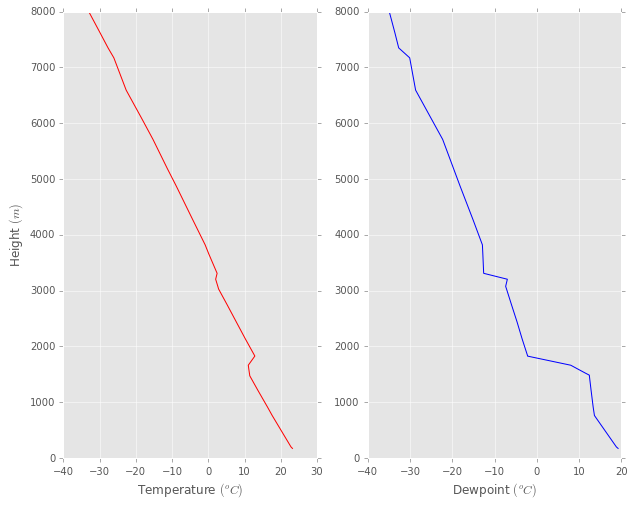

In [252]:
# ======================================
# slice dataframe to reduce computations
# ======================================

indexes = df_sounding.hght<= 9000.
truncated_df = df_sounding[indexes]

%matplotlib inline

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,8))
ax1.plot(truncated_df.temp, truncated_df.hght, 'r')
ax2.plot(truncated_df.dwpt, truncated_df.hght, 'b')
ax1.set_ylabel('Height $(m)$')
ax1.set_xlabel('Temperature $(^oC)$')
ax2.set_xlabel('Dewpoint $(^oC)$')

ax1.set_ylim(0., 8000.)
ax2.set_ylim(0., 8000.)

# Problem 2

redraw your problem 1 figure, adding the moist adiabat for the lowest point (172 meters) 

In [253]:
from a405thermo.thermlib import find_lcl, find_thetaet

# =========================================================================
# since we know the index of the lowest point, we can specfic the index [0]
# =========================================================================

parcel_data = df_sounding.loc[0]
print(parcel_data)

pres    991.0
hght    172.0
temp     23.2
dwpt     19.2
Name: 0, dtype: float64


In [254]:
# =========================================================================
# functions from here require switching between degC / Kelvin, and hPa / Pa
# =========================================================================
def CtoK(temp):
    return temp + 273.15

def KtoC(temp):
    return temp - 273.15

def hPa_to_Pa(pres):
    return pres * 100.

def Pa_to_hPa(pres):
    return pres / 100.

# =============================================================================================
# find lifting condensation level attributes of parcel, keep parcel data as an 'mini dataframe' 
# never know when package of parcel_data will be useful in future!
# =============================================================================================

parcel_data['lcl_temp'], parcel_data['lcl_pres'] = find_lcl(CtoK(parcel_data.dwpt), CtoK(parcel_data.temp), 
                                                            hPa_to_Pa(parcel_data.pres))

parcel_data.lcl_temp = KtoC(parcel_data.lcl_temp)
parcel_data.lcl_pres = Pa_to_hPa(parcel_data.lcl_pres)

# ==================================================
# Note: at lifting condensation level rv = rT = rsat
# ==================================================

parcel_data['rT'] = find_rsat(CtoK(parcel_data.lcl_temp), hPa_to_Pa(parcel_data.lcl_pres))

# ================================================================================================
# Now we can find the equivalent potential temperaure which will be conserved from the LCL upwards
# ================================================================================================

parcel_data['lcl_thetaet'] = find_thetaet(CtoK(parcel_data.dwpt), parcel_data.rT, CtoK(parcel_data.lcl_temp),
                                          hPa_to_Pa(parcel_data.lcl_pres))

print(parcel_data)

pres           991.000000
hght           172.000000
temp            23.200000
dwpt            19.200000
lcl_temp        18.246981
lcl_pres       933.978646
rT               0.014271
lcl_thetaet    335.660739
Name: 0, dtype: float64


(0.0, 8000.0)

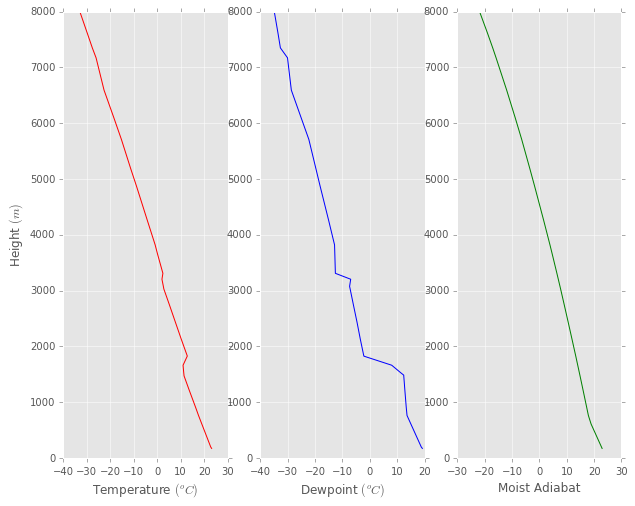

In [255]:
# ===========================================================================
# Producing values for true adiabat, using conservation of entropy
# Entropy calculated at LCL, then adiabat plotted from surface up through LCL
# ===========================================================================

moist_adiabat = []
rv_list = []
rl_list = []

for pres in truncated_df.pres:
    temp, rv, rl = tinvert_thetae(parcel_data.lcl_thetaet, parcel_data.rT, hPa_to_Pa(pres))
    moist_adiabat.append(KtoC(temp))
    rv_list.append(rv)
    rl_list.append(rl)

fig, (ax1,ax2, ax3) = plt.subplots(1,3,figsize=(10,8))
ax1.plot(truncated_df.temp, truncated_df.hght, 'r')
ax2.plot(truncated_df.dwpt, truncated_df.hght, 'b')
ax3.plot(moist_adiabat, truncated_df.hght, 'g')
ax1.set_ylabel('Height $(m)$')
ax1.set_xlabel('Temperature $(^oC)$')
ax2.set_xlabel('Dewpoint $(^oC)$')
ax3.set_xlabel('Moist Adiabat')
ax1.set_ylim(0., 8000.)
ax2.set_ylim(0., 8000.)
ax3.set_ylim(0., 8000.)

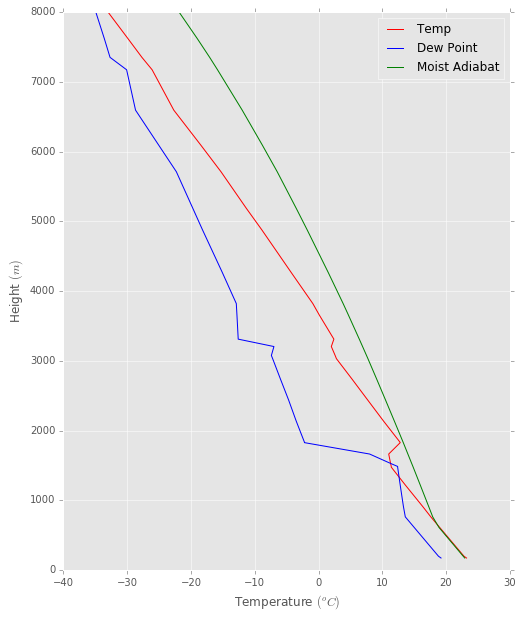

In [256]:
# ====================
# Plotted all together
# ====================

fig1 = plt.figure(figsize=(8,10))
ax1 = fig1.add_subplot(111)
line1 = ax1.plot(truncated_df.temp, truncated_df.hght, 'r', label='Temp')
line2 = ax1.plot(truncated_df.dwpt, truncated_df.hght, 'b', label='Dew Point')
line3 = ax1.plot(moist_adiabat, truncated_df.hght, 'g', label='Moist Adiabat')
ax1.set_ylim(0., 8000.)
ax1.set_xlabel('Temperature $(^oC)$')
ax1.set_ylabel('Height $(m)$')
ax1.legend()

# Problem 3

Write a function that takes as input the dataframe and a height, and finds rv, rl and the buoyancy at that
height.   Use it to calculate rv, rl and the buoyancy for air from 172 meters lifted to 4 km.


In [257]:
# ==============================================================================================================
# Function uses most of the same mechanisims as used in the first two problems - but everything has been copied
# into here to be explicit and allow for a stand-alone function
# ==============================================================================================================

def problem_3_solver(dataframe, height):
    """
    dataframe, float --> float, float, float
    
    Takes a dataframe from balloon sounding data and a specified height (m); returns the vapour and liquid water
    content, and the buoyancy of a parcel specified height after begin lifted from the surface
    
    Inputs:
        dataframe: balloon sounding data of temp, dewpoint, pressure, heights.
        height = height desire to be investigated, meters.
        
    Outputs:
        parcel_buoyancy = buoyancy, m/s/s
        rv = water vapour mixing ratio, kg/kg
        rl = liquid water mixing ratio, kg/kg
    
    Example:
    >>> buoy, rv, rl = problem_3_solver(df_sounding, 4000.)
    0.0804686251254, 0.007613327799567341, 0.006657843034082308 # m/s/s, kg/kg, kg/kg
    """
    
    # imports and unit conversion functions
    from a405thermo.thermlib import find_rvrl, find_buoy, find_lcl, find_thetaet, tinvert_thetae, find_rsat, find_Tv
    from scipy.interpolate import interp1d as interp

    def CtoK(temp):
        return temp + 273.15

    def KtoC(temp):
        return temp - 273.15

    def hPa_to_Pa(pres):
        return pres * 100.

    def Pa_to_hPa(pres):
        return pres / 100.
    
    # obtain basic parcel data for a parcel raised formt he surface in any sounding dataframe
    parcel_data = dataframe.loc[0]
    
    parcel_data['lcl_temp'], parcel_data['lcl_pres'] = find_lcl(CtoK(parcel_data.dwpt), CtoK(parcel_data.temp), 
                                                            hPa_to_Pa(parcel_data.pres))
    
    parcel_data.lcl_temp = KtoC(parcel_data.lcl_temp)
    
    parcel_data.lcl_pres = Pa_to_hPa(parcel_data.lcl_pres)
    
    parcel_data['rT'] = find_rsat(CtoK(parcel_data.lcl_temp), hPa_to_Pa(parcel_data.lcl_pres))
    
    parcel_data['lcl_thetaet'] = find_thetaet(CtoK(parcel_data.dwpt), parcel_data.rT, CtoK(parcel_data.lcl_temp),
                                              hPa_to_Pa(parcel_data.lcl_pres))
    
    indexes = dataframe.hght<= 9000.
    truncated_data = dataframe[indexes]
    
    # find the moist adiabat the parcel will follow after reaching lcl
    moist_adiabat = []
    rv_list = []
    rl_list = []
    
    for pres in truncated_data.pres:
        temp, rv, rl = tinvert_thetae(parcel_data.lcl_thetaet, parcel_data.rT, hPa_to_Pa(pres))
        moist_adiabat.append(temp)
        rv_list.append(rv)
        rl_list.append(rl)
    
    # constuct a list of virtual temperatures for the environment
    env_Tv = []
    for temp in truncated_data.temp:
        Tv_temp = find_Tv(CtoK(temp), parcel_data.rT)
        env_Tv.append(Tv_temp)
    
    # construct a list of virtual temperatures for the moist adiabat
    adiabat_Tv = []
    for i in range(0, len(truncated_data)):
        Tv_temp = find_Tv(moist_adiabat[i], rv_list[i], rl_list[i])
        adiabat_Tv.append(Tv_temp)
        
    # Use interp1d to get interpolated values at 'height' for both environmental and adiabatic Tv; rv; and rl
    f = interp(truncated_data.hght, env_Tv)
    new_env_Tv = f(height)
    
    f = interp(truncated_data.hght, adiabat_Tv)
    new_adiabat_Tv = f(height)
    
    f = interp(truncated_data.hght, rv_list)
    new_rv = f(height)
    
    f = interp(truncated_data.hght, rl_list)
    new_rl = f(height)
    
    # now find buoyancy of parcel lifted from surface to height 'height'
    parcel_buoyancy = find_buoy(new_adiabat_Tv, new_env_Tv)
    
    return parcel_buoyancy, new_rv, new_rl

In [258]:
buoy, rv, rl = problem_3_solver(df_sounding, 4000.)

print('At 4km, a parcel has buoyancy of %.4f m/s/s, rv of %.4f kg/kg, and rl of %.4f kg/kg' %(buoy, rv, rl))

At 4km, a parcel has buoyancy of 0.0805 m/s/s, rv of 0.0076 kg/kg, and rl of 0.0067 kg/kg


# Problem 4

Calculate and make a plot of the virtual temperature of mixtures of adiabatic air from 172 meters and environmental air at 4 km.
Use 20 mixtures evenly spaced between (100% cloud, 0% environment) and (0 %cloud, 100% environment).
Plot the mixing fraction on the x axis and the virtual temperature on the y axis.

In [259]:
# =================================================================================================
# Plan:
# 1. find theta_e of both environemnt and cloud at 4km. These can be mixed based on conservation of entropy.
# 2. mix theta_e's according to mixing fractions.
# 3. tinvert_thetae to get temp of new mixture.
# 4. find_Tv to get virtual temp of mixture
# 5. pair Tv with mixing fractions
# =================================================================================================

from a405thermo.thermlib import find_Tv
from scipy.interpolate import interp1d as interp

# height of interest 4km
height = 4000. 

# interpolate the 4km values that we need to proceed
f = interp(truncated_df.hght, truncated_df.temp)
env_temp = f(height)

f = interp(truncated_df.hght, moist_adiabat)
adiabat_temp = f(height)

f = interp(truncated_df.hght, truncated_df.dwpt)
env_dwpt = f(height)

f = interp(truncated_df.hght, rv_list)
cloud_rv = f(height)
    
f = interp(truncated_df.hght, rl_list)
cloud_rl = f(height)

cloud_rT = cloud_rv + cloud_rl

f = interp(truncated_df.hght, truncated_df.pres)
height_pres = f(height)

# =======================================
# Print and compare to plot in question 2
# =======================================

print(env_temp, adiabat_temp, env_dwpt, height_pres)

-2.2691275167785236 2.909287393575946 -13.785906040268456 623.6241610738255


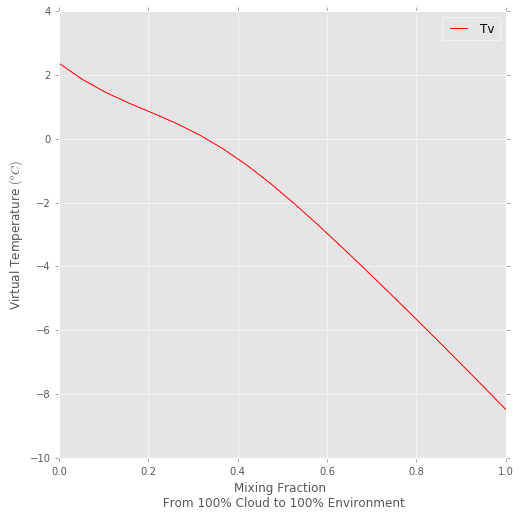

In [260]:
# ============================================================
# thetae values for 4km, assuming cloud is saturated ie Td = T
# ============================================================

env_thetae_master = find_thetaet(CtoK(env_dwpt),parcel_data.rT, CtoK(env_temp), hPa_to_Pa(height_pres))
cloud_thetae_master = find_thetaet(CtoK(adiabat_temp), cloud_rT, CtoK(adiabat_temp), hPa_to_Pa(height_pres))

# now we can mix thetae values
fractions = np.linspace(0., 1., 20)

mixed_Tv_array = []
mixing_fraction = []

# loop thru the fraction values to make 20 mixtures
for frac in fractions:
    env_thetae = env_thetae_master * frac
    cloud_thetae = cloud_thetae_master * (1. - frac)
    mixed_thetae = (env_thetae + cloud_thetae)
 
    env_rT = parcel_data.rT * frac
    cloud_rT = cloud_rT * (1. - frac)
    mixed_rT = env_rT + cloud_rT
    
    mixed_temp, mixed_rv, mixed_rl = tinvert_thetae(mixed_thetae, mixed_rT, hPa_to_Pa(height_pres))
    mixed_Tv = find_Tv(mixed_temp, mixed_rv, mixed_rl)

    mixed_Tv_array.append(KtoC(mixed_Tv))
    mixing_fraction.append(frac)

# plot the results
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111)
line1 = ax1.plot(mixing_fraction, mixed_Tv_array, 'r', label='Tv')
ax1.set_xlabel('Mixing Fraction \n From 100% Cloud to 100% Environment')
ax1.set_ylabel('Virtual Temperature $(^oC)$')
ax1.legend()

### Thanks Phil - See you on May 9th  for some more Python fun !